In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import random
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten 
from sklearn.model_selection import train_test_split

from sklearn import metrics
from statistics import mean

# Loading dataset

In [2]:
data_dir = "C:/Users/Ben-Jason/Desktop/Skripsie/BMW data - Copy/"

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [4]:
list(data_dir.glob('*/*.png'))[:5]

[WindowsPath('C:/Users/Ben-Jason/Desktop/Skripsie/BMW data - Copy/Defects/AN149794_Harness_1.png'),
 WindowsPath('C:/Users/Ben-Jason/Desktop/Skripsie/BMW data - Copy/Defects/AN149817_Harness_1.png'),
 WindowsPath('C:/Users/Ben-Jason/Desktop/Skripsie/BMW data - Copy/Defects/AN149841_Harness_1.png'),
 WindowsPath('C:/Users/Ben-Jason/Desktop/Skripsie/BMW data - Copy/Defects/AN149851_Harness_0.png'),
 WindowsPath('C:/Users/Ben-Jason/Desktop/Skripsie/BMW data - Copy/Defects/AN150298_Harness_1.png')]

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2895


In [6]:
Non_Defects = list(data_dir.glob('Non_Defects/*'))
Defects = list(data_dir.glob('Defects/*'))
#Image.open(str(Non_Defects[0]))

# Read images from disk into numpy array using opencv

In [7]:
BMW_images_dict = {
    'Non_Defects': list(data_dir.glob('Non_Defects/*')),
    'Defects': list(data_dir.glob('Defects/*'))
}

In [8]:
BMW_labels_dict = {
    'Non_Defects': 0,
    'Defects': 1
}

### Resize images and store as X and labels as Y

In [9]:
IMAGE_SHAPE = (224, 224)

In [10]:
X, y = [], []

for BMW_Class, images in BMW_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(IMAGE_SHAPE))
        X.append(resized_img)
        y.append(BMW_labels_dict[BMW_Class])

In [11]:
X = np.array(X)
y = np.array(y)

### Train, test, validation split

In [12]:
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Produces test split.
X_remaining, X_test, y_remaining, y_test = train_test_split(
    X, y, test_size=ratio_test, stratify = y, random_state = 1)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, y_train, y_val = train_test_split(
    X_remaining, y_remaining, test_size = ratio_val_adjusted, stratify = y_remaining, random_state = 1)


print(len(X_train), len(X_val), len(X_test))

2025 435 435


In [13]:
non_defect_count = y_train < 0.5
print(sum(non_defect_count))

1989


### Pre-processing: Scale images

In [14]:
X_train_scaled = X_train / 255
X_val_scaled = X_val / 255
X_test_scaled = X_test / 255

# Now take pre-trained model and retrain it using BMW images

In [15]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

### Set initial bias

In [16]:
totals = np.bincount(y_train)
pos = totals[1]
neg = totals[0]
initial_bias = np.log([pos/neg])
initial_bias
output_bias = tf.keras.initializers.Constant(initial_bias)

### Build model

In [48]:
dense_layer_output_size = 1

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(dense_layer_output_size, activation = 'sigmoid', use_bias = True, bias_initializer = output_bias)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## Compile and train 

In [49]:
model.compile(
  optimizer = "adam",
  loss = 'binary_crossentropy',
  metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [50]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 5) # Model stop training after 40 epoch where validation loss didnt decrease
mc = ModelCheckpoint('C:/Users/Ben-Jason/Desktop/Skripsie/modelsbest_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True) #You save model weight at the epoch where validation loss is minimal

history = model.fit(X_train_scaled, y_train, batch_size = 16, epochs = 50, verbose = 1, validation_data = (X_val_scaled, y_val), callbacks=[es,mc])#you can run for 1000 epoch btw model will stop after 40 epoch without better validation loss
#ran for 20 epochs so far 

Epoch 1/50
127/127 [==============================] - ETA: 0s - loss: 0.0936 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.07510, saving model to C:/Users/Ben-Jason/Desktop/Skripsie\modelsbest_model.h5
127/127 [==============================] - 54s 351ms/step - loss: 0.0936 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - val_loss: 0.0751 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 2/50
127/127 [==============================] - ETA: 0s - loss: 0.0657 - recall_7: 0.0278 - precision_7: 1.0000
Epoch 2: val_loss did not improve from 0.07510
127/127 [==============================] - 30s 238ms/step - loss: 0.0657 - recall_7: 0.0278 - precision_7: 1.0000 - val_loss: 0.0778 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 3/50
127/127 [==============================] - ETA: 0s - loss: 0.0554 - recall_7: 0.1111 - precision_7: 1.0000
Epoch 3: val_loss improved from 0.07510 to 0.06215, saving model to C:/Users/Ben-Ja

In [52]:
seewhat = model.evaluate(X_test_scaled, y_test)
print("Evaluate on test data")
print("test loss, test acc:", seewhat)

14/14 [==============================] - 5s 383ms/step - loss: 0.0469 - recall_7: 0.3750 - precision_7: 1.0000
Evaluate on test data
test loss, test acc: [0.04691505432128906, 0.375, 1.0]


## To load saved model 

In [53]:
from keras.models import load_model
loaded_model = load_model("C:/Users/Ben-Jason/Desktop/Skripsie/modelsbest_model.h5", custom_objects={'KerasLayer':hub.KerasLayer})

### Compile and evaluate 

In [54]:
loaded_model.compile(
  optimizer = "adam",
  loss = 'binary_crossentropy',
  metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

seewhat = loaded_model.evaluate(X_test_scaled, y_test)
print("Evaluate on test data")
print("test loss, test acc:", seewhat)

14/14 [==============================] - 6s 344ms/step - loss: 0.0433 - recall_8: 0.3750 - precision_8: 1.0000
Evaluate on test data
test loss, test acc: [0.04332904890179634, 0.375, 1.0]


### Testing again on test and training sets 

TEST SET
14/14 [==============================] - 6s 372ms/step


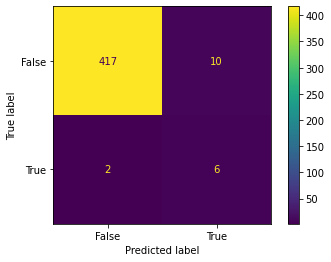

Defect scores on average is: [0.26962563]
Non-defect scores on average is: [0.00435149]
TRAINING SET
64/64 [==============================] - 26s 389ms/step


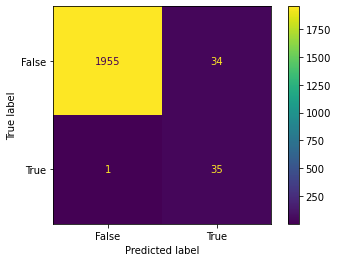

Defect scores on average is: [0.6531685]
Non-defect scores on average is: [0.00343015]
VALIDATION SET
14/14 [==============================] - 5s 371ms/step


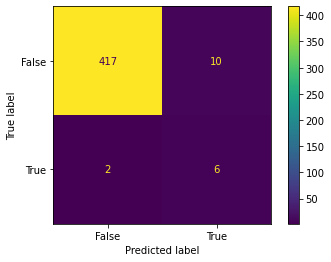

Defect scores on average is: [0.2800462]
Non-defect scores on average is: [0.0049031]


In [43]:
#Test set
print("TEST SET")
y_pred_test = model.predict(X_test_scaled)
y_pred_test_bin = y_pred_test > 0.04
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

print("Defect scores on average is:", sum(y_pred_test[np.where(y_test == 1)])/len(y_pred_test[np.where(y_test == 1)]))
print("Non-defect scores on average is:", sum(y_pred_test[np.where(y_test == 0)])/len(y_pred_test[np.where(y_test == 0)]))


#Training set 
print("TRAINING SET")
y_pred_train = model.predict(X_train_scaled)
y_pred_train_bin = y_pred_train > 0.04
confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

print("Defect scores on average is:", sum(y_pred_train[np.where(y_train == 1)])/len(y_pred_train[np.where(y_train == 1)]))
print("Non-defect scores on average is:", sum(y_pred_train[np.where(y_train == 0)])/len(y_pred_train[np.where(y_train == 0)]))


#Validation set
print("VALIDATION SET")
y_pred_val = model.predict(X_val_scaled)
y_pred_val_bin = y_pred_val > 0.04
confusion_matrix = metrics.confusion_matrix(y_val, y_pred_val_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

print("Defect scores on average is:", sum(y_pred_val[np.where(y_val == 1)])/len(y_pred_val[np.where(y_val == 1)]))
print("Non-defect scores on average is:", sum(y_pred_val[np.where(y_val == 0)])/len(y_pred_val[np.where(y_val == 0)]))




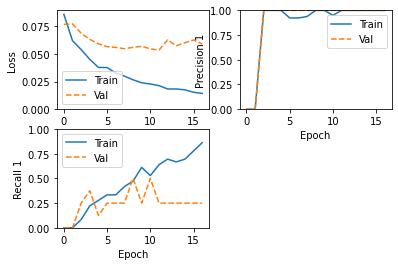

In [45]:
def plot_metrics(history):
  metrics = ['loss', 'precision_1', 'recall_1']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();
    
plot_metrics(history)


## Visualize defect images and corresponding activations predicted

### For training images:

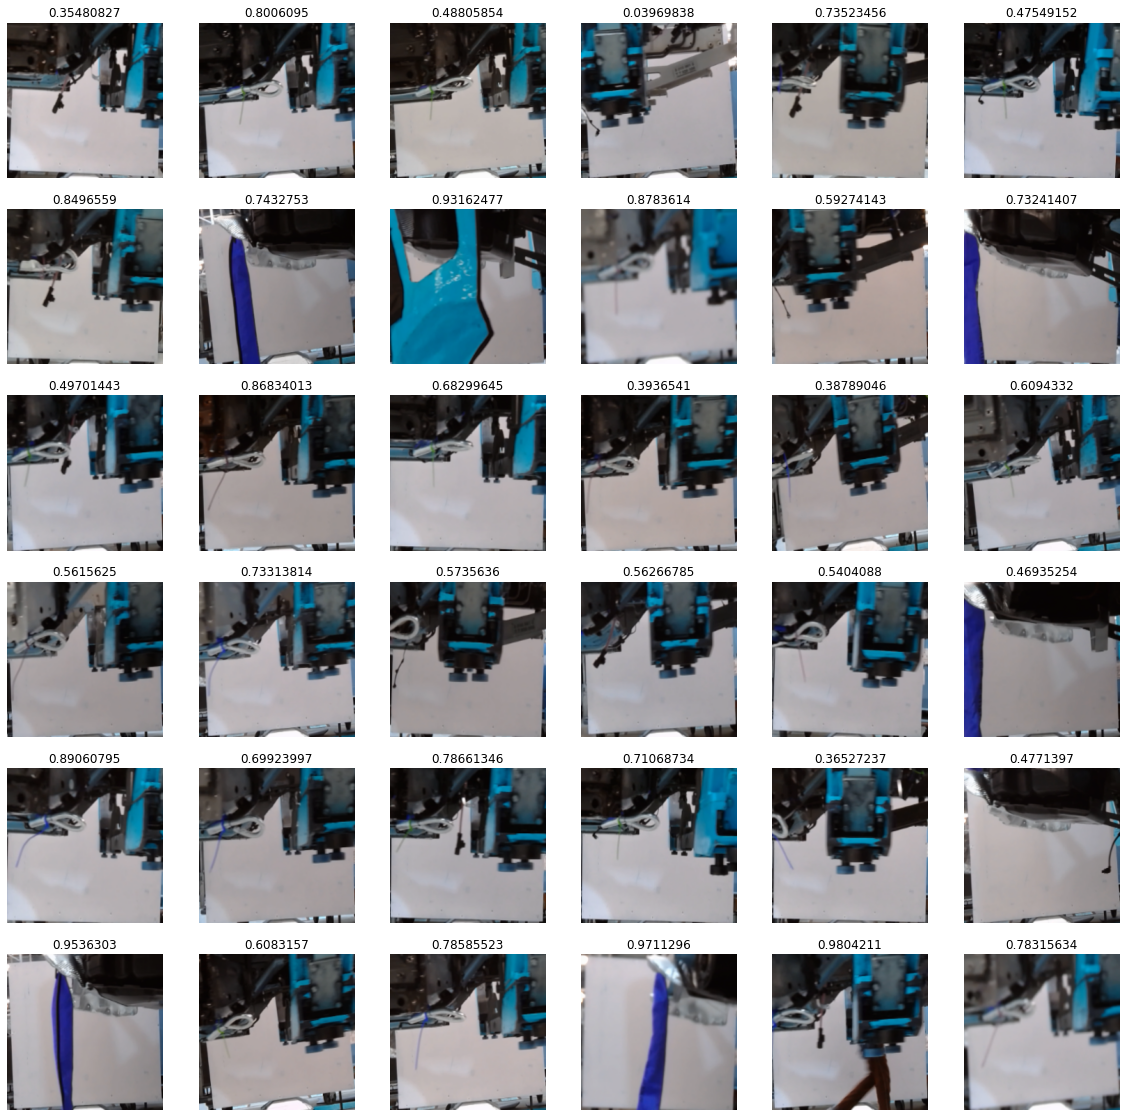

In [46]:
plt.figure(figsize=(20, 20))
tupl = np.where(y_train == 1)
arr = np.asarray(tupl)
flatarr = arr.flatten()
labels = y_pred_train[np.where(y_train == 1)]
larr = np.asarray(labels)
labels = larr.flatten() 

for index, element in enumerate(flatarr):
    ax = plt.subplot(6, 6, index + 1)
    plt.imshow(np.squeeze(X_train[element]))
    plt.title(labels[index])
    plt.axis("off")
   

### For test images:

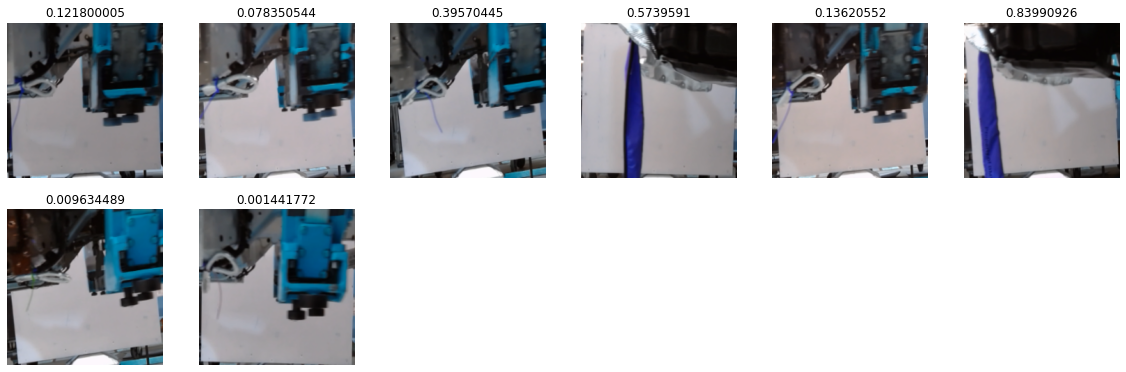

In [51]:
plt.figure(figsize=(20, 20))
tupl = np.where(y_test == 1)
arr = np.asarray(tupl)
flatarr = arr.flatten()
labels = y_pred_test[np.where(y_test == 1)]
larr = np.asarray(labels)
labels = larr.flatten() 

for index, element in enumerate(flatarr):
    ax = plt.subplot(6, 6, index + 1)
    plt.imshow(np.squeeze(X_test[element]))
    plt.title(labels[index])
    plt.axis("off")
   

### For validation images:

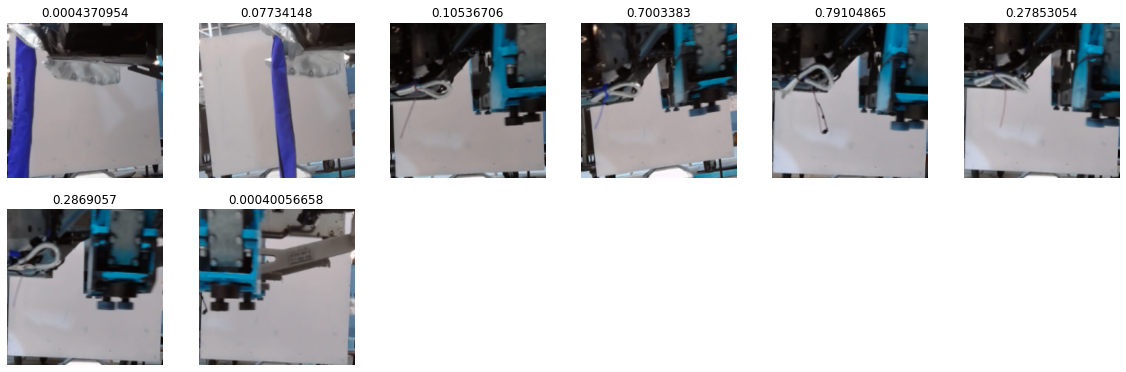

In [50]:
plt.figure(figsize=(20, 20))
tupl = np.where(y_val == 1)
arr = np.asarray(tupl)
flatarr = arr.flatten()
labels = y_pred_val[np.where(y_val == 1)]
larr = np.asarray(labels)
labels = larr.flatten() 

for index, element in enumerate(flatarr):
    ax = plt.subplot(6, 6, index + 1)
    plt.imshow(np.squeeze(X_val[element]))
    plt.title(labels[index])
    plt.axis("off")

## Visualize some non-defect images and corresponding activations predicted

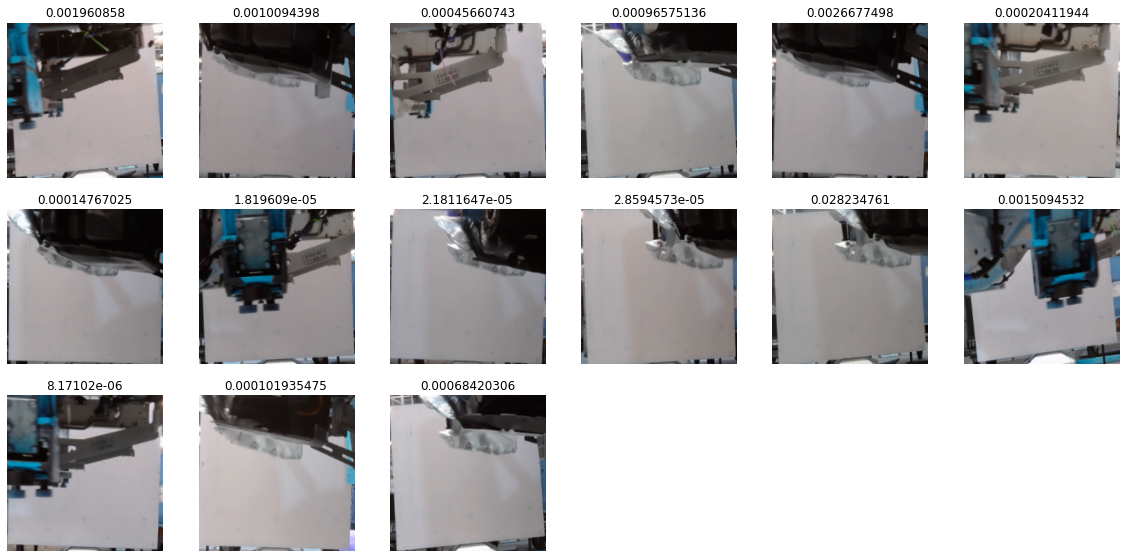

In [52]:
plt.figure(figsize=(20, 20))
tupl = np.where(y_train == 0)
arr = np.asarray(tupl)
flatarr = arr.flatten()[0:15]
labels = y_pred_train[np.where(y_val == 0)]
larr = np.asarray(labels)
labels = larr.flatten()[0:15]

for index, element in enumerate(flatarr):
    ax = plt.subplot(6, 6, index + 1)
    plt.imshow(np.squeeze(X_train[element]))
    plt.title(labels[index])
    plt.axis("off")

### For test images:

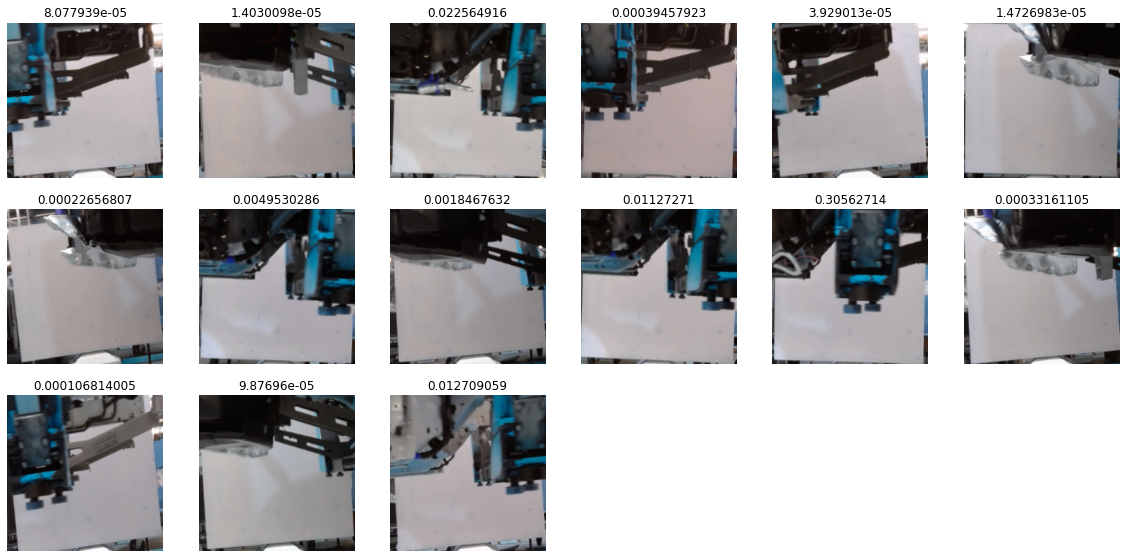

In [53]:
plt.figure(figsize=(20, 20))
tupl = np.where(y_test == 0)
arr = np.asarray(tupl)
flatarr = arr.flatten()[0:15]
labels = y_pred_test[np.where(y_test == 0)]
larr = np.asarray(labels)
labels = larr.flatten()[0:15]

for index, element in enumerate(flatarr):
    ax = plt.subplot(6, 6, index + 1)
    plt.imshow(np.squeeze(X_test[element]))
    plt.title(labels[index])
    plt.axis("off")

### For validation images:

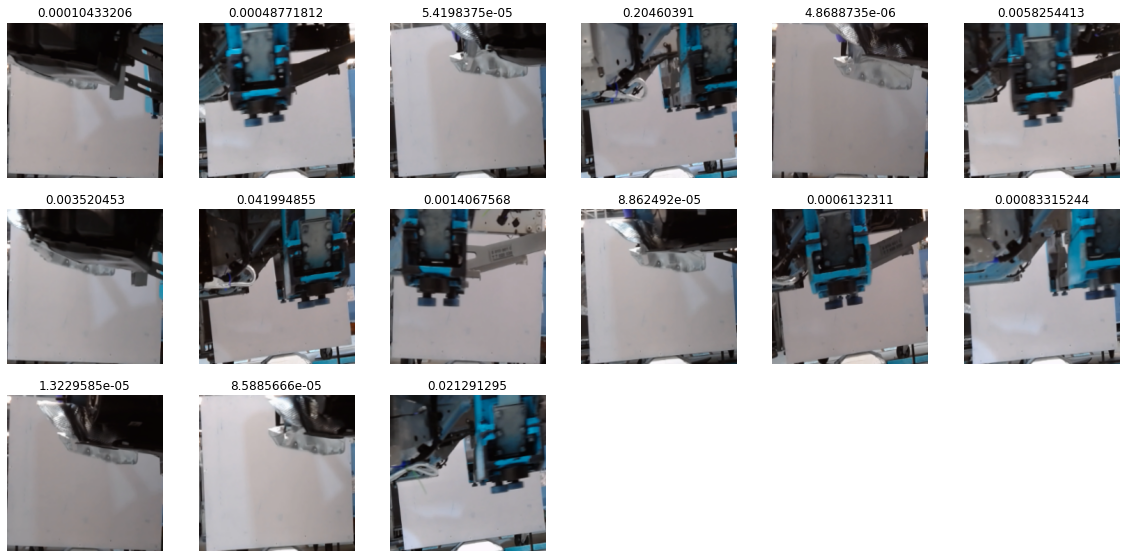

In [54]:
plt.figure(figsize=(20, 20))
tupl = np.where(y_val == 0)
arr = np.asarray(tupl)
flatarr = arr.flatten()[0:15]
labels = y_pred_val[np.where(y_val == 0)]
larr = np.asarray(labels)
labels = larr.flatten()[0:15]

for index, element in enumerate(flatarr):
    ax = plt.subplot(6, 6, index + 1)
    plt.imshow(np.squeeze(X_val[element]))
    plt.title(labels[index])
    plt.axis("off")

## Plot of Precision-recall curve

In [74]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

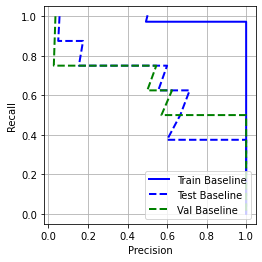

In [76]:
plot_prc("Train Baseline", y_train, y_pred_train, color= 'b')
plot_prc("Test Baseline", y_test, y_pred_test, color= 'b', linestyle='--')
plot_prc("Val Baseline", y_val, y_pred_val, color= 'g', linestyle='--')
plt.legend(loc='lower right')

## AUC-PR (go check the difference between the two ways of calculating - sklearn AP vs keras AUC-PR)

In [81]:
AP = metrics.average_precision_score(y_test, y_pred_test)
AP

0.6514870546120546